## Адаптация подхода статьи "[Automatic Scoring of English Essays Based on Machine Learning Technology in a Wireless Network Environment](https://www.hindawi.com/journals/scn/2022/9336298/#EEq5)" к автопроверке письменной части ЕГЭ по английскому языку.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
email_data = pd.read_csv('email_data.csv')

data_to_work = email_data.sample(n=300)

### 3.2.2. Linguistic Feature Extraction and Filtering

In [ ]:
!pip install autocorrect
!pip install language_tool_python
!pip install textstat

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from textstat import syllable_count, flesch_reading_ease, flesch_kincaid_grade, gunning_fog
from autocorrect import Speller
import language_tool_python
from nltk.corpus import wordnet as wn
from nltk import word_tokenize

spell = Speller(lang="en")

def lexical_chains(text):
    chains = []
    words = word_tokenize(text)
    for word in words:
        synsets = wn.synsets(word)
        if synsets:
            chain = set()
            for synset in synsets:
                chain.update(synset.lemma_names())
            chains.append(chain)
    return chains
tool = language_tool_python.LanguageTool('en-US')

# Очищаем текст от знаков препинания, цифр, стоп-слов и приводим к нижнему регистру
# data_to_work["Text"] = data_to_work["Text"].str.replace("[^a-zA-Z]", " ") # Удаляем все, кроме букв
# data_to_work["Text"] = data_to_work["Text"].str.lower() # Приводим к нижнему регистру
# stop_words = stopwords.words("english") # Загружаем список стоп-слов
# data_to_work["Text"] = data_to_work["Text"].apply(lambda x: " ".join([w for w in x.split() if w not in stop_words])) # Удаляем стоп-слова

# Вычисляем поверхностные признаки на основе длины текста
data_to_work["LEN_CHAR"] = data_to_work["Text"].apply(len) # Количество символов
data_to_work["LEN_WORD"] = data_to_work["Text"].apply(lambda x: len(x.split())) # Количество слов
data_to_work["LEN_PUNCT"] = data_to_work["Text"].apply(lambda x: len([c for c in x if c in ".,:;!?"])) # Количество знаков препинания
data_to_work["LEN_SENT"] = data_to_work["Text"].apply(lambda x: len(sent_tokenize(x))) # Количество предложений
data_to_work["LEN_PARA"] = data_to_work["Text"].apply(lambda x: len(x.split("\n"))) # Количество абзацев
data_to_work["LEN_AWL"] = data_to_work["Text"].apply(lambda x: np.mean([len(w) for w in x.split()])) # Средняя длина слова
data_to_work["LEN_ASL"] = data_to_work["Text"].apply(lambda x: np.mean([len(s.split()) for s in sent_tokenize(x)])) # Средняя длина предложения

# Вычисляем показатели читабельности текста
data_to_work["RE_AWS"] = data_to_work["Text"].apply(lambda x: np.mean([syllable_count(w) for w in x.split()])) # Среднее количество слогов в слове
data_to_work["RE_CWR"] = data_to_work["Text"].apply(lambda x: len([w for w in x.split() if syllable_count(w) > 2]) / len(x.split())) # Доля сложных слов (больше двух слогов)
data_to_work["RE_FOG"] = data_to_work["Text"].apply(gunning_fog) # Индекс читабельности FOG
data_to_work["RE_FLESCH"] = data_to_work["Text"].apply(flesch_reading_ease) # Индекс читабельности FLESCH
data_to_work["RE_KINCAID"] = data_to_work["Text"].apply(flesch_kincaid_grade) # Индекс читабельности KINCAID

# Вычисляем лексическое разнообразие текста
data_to_work["TTR"] = data_to_work["Text"].apply(lambda x: len(set(x.split())) / len(x.split())) # Отношение количества разных слов к общему количеству слов
data_to_work["TTR_ROOT"] = data_to_work["Text"].apply(lambda x: len(set(x.split())) / np.sqrt(len(x.split()))) # Корень из отношения количества разных слов к общему количеству слов
data_to_work["TTR_LOG"] = data_to_work["Text"].apply(lambda x: np.log(len(set(x.split()))) / np.log(len(x.split()))) # Логарифм отношения количества разных слов к общему количеству слов
data_to_work["TTR_SEG"] = data_to_work["Text"].apply(lambda x: np.mean([len(set(s.split())) / len(s.split()) for s in sent_tokenize(x)])) # Среднее отношение количества разных слов к общему количеству слов по предложениям
data_to_work["TTR_RAND"] = data_to_work["Text"].apply(lambda x: np.mean([len(set(np.random.choice(x.split(), size=len(x.split()), replace=False))) / len(x.split()) for _ in range(10)])) # Среднее отношение количества разных слов к общему количеству слов по случайным выборкам

# Вычисляем сложность синтаксиса текста
data_to_work["pos"] = data_to_work["Text"].apply(lambda x: pos_tag(word_tokenize(x))) # Определяем часть речи для каждого слова в тексте
data_to_work["SYN_C"] = data_to_work["pos"].apply(lambda x: len([w for w, t in x if t in ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]])) # Количество синтаксических единиц (существительных и глаголов)
data_to_work["SYN_DC"] = data_to_work["pos"].apply(lambda x: len([w for w, t in x if t in ["WDT", "WP", "WP$", "WRB", "IN"]])) # Количество подчинительных союзов
data_to_work["SYN_VP"] = data_to_work["pos"].apply(lambda x: len([w for w, t in x if t.startswith("VB")])) # Количество глагольных групп
data_to_work["SYN_CN"] = data_to_work["pos"].apply(lambda x: len([w for w, t in x if t in ["JJ", "JJR", "JJS", "DT", "PDT", "PRP$", "POS", "CD"]])) # Количество сложных существительных групп
data_to_work["SYN_CP"] = data_to_work["pos"].apply(lambda x: len([w for w, t in x if t in ["CC", ":", ";"]])) # Количество параллельных групп
data_to_work["SYN_C"] = data_to_work["SYN_C"] / data_to_work["LEN_SENT"] # Доля синтаксических единиц
data_to_work["SYN_DC"] = data_to_work["SYN_DC"] / data_to_work["LEN_SENT"] # Доля подчинительных союзов
data_to_work["SYN_VP"] = data_to_work["SYN_VP"] / data_to_work["LEN_SENT"] # Доля глагольных групп
data_to_work["SYN_CN"] = data_to_work["SYN_CN"] / data_to_work["LEN_SENT"] # Доля сложных существительных групп
data_to_work["SYN_CP"] = data_to_work["SYN_CP"] / data_to_work["LEN_SENT"] # Доля параллельных групп

# Вычисляем правильность грамматики текста
data_to_work["SPELL_E"] = data_to_work["Text"].apply(lambda x: len([w for w in x.split() if w != spell(w)])) # Количество орфографических ошибок
data_to_work["GRM_E"] = data_to_work["Text"].apply(lambda x: len(tool.check(x))) # Количество сложных грамматических ошибок
data_to_work["SPELL_E/W"] = data_to_work["SPELL_E"] / data_to_work["LEN_WORD"] # Доля орфографических ошибок к общему количеству слов
data_to_work["SPELL_E/S"] = data_to_work["SPELL_E"] / data_to_work["LEN_SENT"] # Доля орфографических ошибок к общему количеству предложений
data_to_work["GRM_E/W"] = data_to_work["GRM_E"] / data_to_work["LEN_WORD"] # Доля сложных грамматических ошибок к общему количеству слов
data_to_work["GRM_E/S"] = data_to_work["GRM_E"] / data_to_work["LEN_SENT"] # Доля сложных грамматических ошибок к общему количеству предложений

# Вычисляем связность дискурса текста
data_to_work["Links_local"] = data_to_work["Text"].apply(lambda x: len([w for s in sent_tokenize(x) for w in ngrams(s.split(), 2) if w in lexical_chains(x)])) # Количество лексических связей между соседними предложениями
data_to_work["Links_global"] = data_to_work["Text"].apply(lambda x: len([w for w in ngrams(x.split(), 2) if w in lexical_chains(x)])) # Количество лексических связей между любыми двумя предложениями
data_to_work["COH_LOCAL"] = data_to_work["Links_local"] / data_to_work["LEN_SENT"] # Доля лексических связей между соседними предложениями
data_to_work["COH_GLOBAL"] = data_to_work["Links_global"] / data_to_work["LEN_SENT"] # Доля лексических связей между любыми двумя предложениями

In [ ]:
data_to_work.head()

In [ ]:
# Фильтруем лингвистические признаки с помощью алгоритма Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, oob_score=True)
X = data_to_work.drop([" Type", "Question", "Text", "pos", "Overall_score", "Solving a communicative task",	"Text structure",	"Use of English (for emails)"], axis=1)
y = data_to_work["Overall_score"]
rf.fit(X, y)
importance = rf.feature_importances_ # Получаем важность каждого признака
X_sub = X.loc[:, importance > 0] # Выбираем признаки с важностью больше 0

In [ ]:
print(X_sub)

In [ ]:
X = X_sub
y = data_to_work["Overall_score"].astype('float32') # баллы за эссе

In [ ]:
# линейная регрессия
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

In [ ]:
# дерево
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке и вычисление ошибки
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {mse}")

In [ ]:
# лес
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {mse}")

###3.2.1. Bag-of-Words Feature Extraction and Filtering

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
train_data = email_data.sample(n=300)

In [ ]:
# Очищаем текст от знаков препинания, цифр и приводим к нижнему регистру
train_data["Text"] = train_data["Text"].str.replace("[^a-zA-Z]", " ", regex=True)
train_data["Text"] = train_data["Text"].str.lower()

In [ ]:
# Разбиваем текст на отдельные слова и последовательности слов длиной от 1 до 3 (n-граммы)
vectorizer = CountVectorizer(ngram_range=(1, 3)) # Создаем объект класса CountVectorizer с параметром ngram_range
X = vectorizer.fit_transform(train_data["Text"]) # Преобразуем текст в матрицу частот слов и последовательностей
vocab = vectorizer.get_feature_names_out() # Получаем список слов и последовательностей из словаря
print("Размер словаря:", len(vocab)) # Выводим размер словаря
print("Первые 10 элементов словаря:", vocab[:10]) # Выводим первые 10 элементов словаря

# Определяем часть речи для каждого слова в тексте с помощью модуля nltk
# nltk.download("punkt") # Скачиваем модуль для токенизации
# nltk.download("averaged_perceptron_tagger") # Скачиваем модуль для определения части речи
train_data["pos"] = train_data["Text"].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x))) # Добавляем новый столбец с кортежами вида (слово, тег)
print("Первые 5 строк с частями речи:")
print(train_data["pos"].head()) # Выводим первые 5 строк с частями речи

# Сгруппировываем слова и последовательности по частям речи и подсчитываем частоту каждой группы
pos_dict = {} # Создаем пустой словарь для хранения частот
for row in train_data["pos"]: # Для каждой строки в столбце pos
    for word, tag in row: # Для каждого кортежа в строке
        if tag not in pos_dict: # Если тега еще нет в словаре
            pos_dict[tag] = 1 # Добавляем его с начальным значением 1
        else: # Если тег уже есть в словаре
            pos_dict[tag] += 1 # Увеличиваем его значение на 1
print("Частота частей речи:")
print(pos_dict)

Размер словаря: 37114
Первые 10 элементов словаря: ['10' '10 minutes' '10 minutes to' '100' '100 necessary'
 '100 necessary because' '11th' '11th floor' '11th floor which' '132']
Первые 5 строк с частями речи:
267    [(Dear, NNP), (Ralph, NNP), (,, ,), (Thanks, N...
224    [(Dear, NNP), (,, ,), (Nora, NNP), (Thanks, VB...
326    [(Dear, NNP), (Mark, NNP), (,, ,), (Thanks, NN...
138    [(Dear, NNP), (Andy, NNP), (,, ,), (Thanks, NN...
341    [(Dear, NNP), (Jane, NNP), (,, ,), (Thank, NNP...
Name: pos, dtype: object
Частота частей речи:
{'NNP': 2093, ',': 2236, 'DT': 2413, 'NN': 5100, 'IN': 4659, 'PRP$': 1964, 'JJ': 2726, '.': 3810, 'PRP': 5008, 'VBP': 2305, 'RB': 2306, 'TO': 1279, 'VB': 2471, 'NNS': 2365, 'VBZ': 1218, 'VBD': 708, 'MD': 419, 'WRB': 394, 'VBG': 616, 'JJR': 220, 'WP': 381, 'JJS': 299, 'CC': 842, 'PDT': 39, 'RBR': 90, 'VBN': 408, 'WDT': 33, ':': 32, 'CD': 72, 'RP': 69, 'FW': 24, ')': 19, 'EX': 51, 'RBS': 27, 'POS': 101, '(': 18, 'UH': 33, '``': 55, 'NNPS': 5, "''": 10}


In [ ]:
# Вычисляем взаимную информацию для каждого слова и последовательности с помощью уравнения (3) из статьи
mi_dict = {} # Создаем пустой словарь для хранения взаимной информации
train_data["Overall_score"] = train_data["Overall_score"].astype(float)
N = len(train_data) # Количество эссе в наборе данных
m = float(train_data["Overall_score"].median()) # Медиана оценок эссе
D_high = train_data[train_data["Overall_score"] >= m] # Подмножество эссе с высокой оценкой
D_low = train_data[train_data["Overall_score"] < m] # Подмножество эссе с низкой оценкой
for v in vocab: # Для каждого слова или последовательности в словаре
    n_11 = len(D_high[D_high["Text"].str.contains(v)]) # Количество эссе с высокой оценкой, содержащих v
    n_12 = len(D_low[D_low["Text"].str.contains(v)]) # Количество эссе с низкой оценкой, содержащих v
    n_21 = len(D_high) - n_11 # Количество эссе с высокой оценкой, не содержащих v
    n_22 = len(D_low) - n_12 # Количество эссе с низкой оценкой, не содержащих v
    n_1p = n_11 + n_12 # Количество эссе, содержащих v
    n_p1 = n_11 + n_21 # Количество эссе с высокой оценкой
    n_2p = n_21 + n_22 # Количество эссе, не содержащих v
    n_p2 = n_12 + n_22 # Количество эссе с низкой оценкой
    # Вычисляем взаимную информацию по формуле из статьи
    mi_v = 0
    if n_11 > 0:
        mi_v += n_11 / N * np.log(N * n_11 / (n_1p * n_p1))
    if n_21 > 0:
        mi_v += n_21 / N * np.log(N * n_21 / (n_2p * n_p1))
    if n_12 > 0:
        mi_v += n_12 / N * np.log(N * n_12 / (n_1p * n_p2))
    if n_22 > 0:
        mi_v += n_22 / N * np.log(N * n_22 / (n_2p * n_p2))
    mi_dict[v] = mi_v # Добавляем в словарь взаимную информацию для v
print("Взаимная информация для слов и последовательностей:")
print(mi_dict) # Выводим словарь с взаимной информацией

# Отфильтровываем слова и последовательности по длине и взаимной информации с помощью уравнения (1) из статьи и заданных пороговых значений
t_len = 1 # Пороговое значение для длины
t_mi = 0.01 # Пороговое значение для взаимной информации
BOW_sub = [] # Создаем пустой список для отфильтрованных слов и последовательностей
for v in vocab: # Для каждого слова или последовательности в словаре
    len_v = len(v.split()) # Вычисляем длину v
    mi_v = mi_dict[v] # Получаем взаимную информацию для v
    if mi_v > t_mi: # Если v удовлетворяет условию фильтрации
        BOW_sub.append(v) # Добавляем v в список
print("Отфильтрованные слова и последовательности:")
print(BOW_sub) # Выводим список с отфильтрованными словами и последовательностями

Взаимная информация для слов и последовательностей:
Отфильтрованные слова и последовательности:
['about', 'about ecotourism', 'about friends', 'about my', 'about you', 'about your', 'about your gran', 'about your sister', 'ages', 'all for', 'always', 'always glad', 'always glad to', 'always help my', 'an exam', 'an online', 'and do the', 'animal', 'animals', 'answer', 'answer you', 'answer you earlier', 'are not as', 'as an', 'as good', 'as good as', 'as it', 'as my', 'as my brother', 'as my father', 'as my friend', 'as real', 'as real ones', 'as we', 'asked', 'asked me', 'asked me about', 'asking', 'asking me', 'asking me for', 'asking me to', 'asks', 'at online', 'author', 'back', 'back soon', 'beautiful', 'because it takes', 'biscuit', 'biscuits', 'biscuits made', 'by', 'camp', 'choose', 'chosen', 'circle', 'circle of', 'circle of friend', 'close friend', 'colour is it', 'could', 'couldn', 'days at', 'did it', 'direct', 'does it function', 'doing well', 'earlier', 'easy to', 'eat', 

In [ ]:
# Взвешиваем частоты слов с помощью бинарного или TF-IDF метода с помощью уравнений (4) и (5) из статьи
method = "tfidf" # Выбираем метод взвешивания
if method == "binary": # Если метод бинарный
    def binary(c): # Определяем функцию бинарного взвешивания
        if c >= 1: # Если частота больше или равна 1
            return 1 # Возвращаем 1
        else: # Иначе
            return 0 # Возвращаем 0
    X_sub = X[:, [vectorizer.vocabulary_.get(v) for v in BOW_sub]] # Выбираем столбцы матрицы X, соответствующие отфильтрованным словам и последовательностям
    X_sub = X_sub.toarray() # Преобразуем матрицу в массив numpy
    binary = np.vectorize(binary, otypes=[int]) # Векторизуем функцию бинарного взвешивания
    X_sub = binary(X_sub) # Применяем функцию бинарного взвешивания к каждому элементу массива
elif method == "tfidf": # Если метод TF-IDF
    df_v = X[:, [vectorizer.vocabulary_.get(v) for v in BOW_sub]].sum(axis=0) # Считаем количество документов, содержащих каждое слово или последовательность
    def tfidf(c, v): # Определяем функцию TF-IDF взвешивания
        return (1 + np.log(c)) * np.log(N / df_v[v]) # Возвращаем произведение логарифма частоты и обратной частоты документа
    X_sub = X[:, [vectorizer.vocabulary_.get(v) for v in BOW_sub]] # Выбираем столбцы матрицы X, соответствующие отфильтрованным словам и последовательностям
    X_sub = X_sub.toarray() # Преобразуем матрицу в массив numpy


y = train_data["Overall_score"]
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=42)

# Обучаем модель SVR на обучающей выборке и предсказываем оценки для валидационной выборки
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2^:", r2)

MSE: 1.2018101895388804
MAE: 0.7542043335556252
R^2^: 0.09011215933964878


### 4. Experiments and Results

In [ ]:
email_data = pd.read_csv('email_data.csv')

# Очищаем текст от знаков препинания, цифр, стоп-слов и приводим к нижнему регистру
email_data["words"] = email_data["Text"].str.replace("[^a-zA-Z]", " ", regex=True) # Удаляем все, кроме букв
email_data["words"] = email_data["words"].str.lower() # Приводим к нижнему регистру
email_data["pos"] = email_data["words"].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x))) # Добавляем новый столбец с кортежами вида (слово, тег)
email_data["Overall_score"] = email_data["Overall_score"].astype('float32')

In [ ]:
from collections import Counter

# Функция для подсчета частей речи
def count_pos(pos_list):
    # Извлекаем только теги частей речи
    tags = [tag for word, tag in pos_list]
    # Подсчитываем количество каждой части речи
    tag_counts = Counter(tags)
    # Преобразуем словарь в строку, где каждая пара "тег-количество" разделена пробелом
    tag_counts_str = ' '.join([f'{tag}:{count}' for tag, count in tag_counts.items()])
    return tag_counts_str

# Применяем функцию к столбцу 'pos'
email_data['pos'] = email_data['pos'].apply(count_pos)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack
import scipy.stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

data = email_data

train, val = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=42)
C = 1
epsilon = 0.1

# Создаем векторизаторы для слов и частей речи
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=N)
pos_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=N)

# Обучаем векторизаторы на обучающей выборке
word_vectorizer.fit(train["words"])
pos_vectorizer.fit(train["pos"])

# Преобразуем обучающую и валидационную выборки в векторы
X_train_words = word_vectorizer.transform(train["words"])
X_train_pos = pos_vectorizer.transform(train["pos"])
X_val_words = word_vectorizer.transform(val["words"])
X_val_pos = pos_vectorizer.transform(val["pos"])

# Объединяем векторы слов и частей речи в один признаковый вектор
X_train = hstack((X_train_words, X_train_pos))
X_val = hstack((X_val_words, X_val_pos))

# Создаем модель линейной регрессии с эпсилон-чувствительной потерей
model = LinearSVR(C=C, epsilon=epsilon, random_state=42)
model.fit(X_train, train["Overall_score"])
val_predictions = model.predict(X_val)

r_2 = np.corrcoef(val["Overall_score"], val_predictions)[0, 1]
rho_2 = scipy.stats.spearmanr(val["Overall_score"], val_predictions)[0]
rmse_2 = np.sqrt(np.mean((val["Overall_score"] - val_predictions) ** 2))
mse = mean_squared_error(val["Overall_score"], val_predictions)
mae = mean_absolute_error(val["Overall_score"], val_predictions)
r2 = r2_score(val["Overall_score"], val_predictions)

print("MSE:", mse)
print("MAE:", mae)
print("R^2^:", r2)
print("Model 2: r = {:.3f}, rho = {:.3f}, rmse = {:.3f}".format(r_2, rho_2, rmse_2))

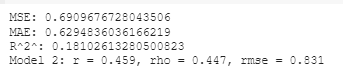

### 4.2. Deep Learning-Based Model Building and Evaluation

In [ ]:
import tensorflow as tf
import sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
import scipy.stats

In [ ]:
X = data_to_work["Text"] # тексты эссе
y = data_to_work["Overall_score"].astype('float32') # баллы за эссе

# Разбиваем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# В общем опять. Можно было не делать, но что б ничего не рушить..

# Создаем словарь из слов и частей речи
vocab = {}
for essay in X_train:
  # Разбиваем эссе на предложения
  sentences = nltk.sent_tokenize(essay)
  for sentence in sentences:
    # Разбиваем предложение на слова
    words = nltk.word_tokenize(sentence)
    # Определяем части речи для слов
    pos_tags = nltk.pos_tag(words)
    # Добавляем слова и части речи в словарь с их частотами
    for word, tag in pos_tags:
      vocab[word] = vocab.get(word, 0) + 1
      vocab[tag] = vocab.get(tag, 0) + 1

# Вычисляем размер словаря
vocab_size = len(vocab.keys())

# Вычисляем размер словаря частей речи
pos_size = 0
for key in vocab.keys():
  if key.isupper(): # предположим, что части речи записаны заглавными буквами
    pos_size += 1

In [ ]:
# Создаем токенизатор и обучаем на текстах
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Преобразуем тексты в последовательности числовых идентификаторов
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Делаем дополнение или обрезку последовательностей, чтобы они все имели одинаковую длину
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=900)
X_val_seq_padded = pad_sequences(X_val_seq, maxlen=900)

In [ ]:
# Создаем словарь из частей речи и их индексов
pos_dict = {}
pos_index = 1
for essay in X_train:
  sentences = nltk.sent_tokenize(essay)
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    for word, tag in pos_tags:
      if tag not in pos_dict:
        pos_dict[tag] = pos_index
        pos_index += 1

# Преобразуем обучающую выборку в последовательности индексов частей речи
X_train_pos = []
for essay in X_train:
  pos_seq = []
  sentences = nltk.sent_tokenize(essay)
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    for word, tag in pos_tags:
      pos_seq.append(pos_dict[tag])
  X_train_pos.append(pos_seq)

# Делаем то же самое с валидационной выборкой
X_val_pos = []
for essay in X_val:
  pos_seq = []
  sentences = nltk.sent_tokenize(essay)
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    for word, tag in pos_tags:
      pos_seq.append(pos_dict[tag])
  X_val_pos.append(pos_seq)

# Это можно было объединить, но как есть.

In [ ]:
# Дополняем последовательности до максимальной длины, иначе дальше с размерностями будут сложности

X_train_pos = pad_sequences(X_train_pos, maxlen=900, padding='post')
X_val_pos = pad_sequences(X_val_pos, maxlen=900, padding='post')
X_train_seq_padded = pad_sequences(X_train_seq_padded, maxlen=900, padding='post')
X_train_pos = pad_sequences(X_train_pos, maxlen=900, padding='post')

In [ ]:
# Задаем параметры моделей

dinput_length = 900 # длина словесной последовательности во входном слое
dword_embedding = 100 # размерность вектора слов
dpos_embedding = 50 # размерность вектора частей речи
h = 20 # количество фильтров в сверточном слое
m = 1 # длина окна свертки
n = 2 # длина окна максимального пулинга
n_model2 = 1 # длина окна максимального пулинга
ddense = 128 # размерность полносвязного слоя
batch_size = 16 # размер пакета для оптимизатора

In [ ]:
# Создаем модель 1, которая использует только словесные последовательности

model_1 = tf.keras.Sequential()
# Добавляем слой Word2vec, который преобразует слова в векторы
model_1.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=dword_embedding, input_length=dinput_length ))
# Добавляем сверточный слой, который применяет фильтры к входному слою
model_1.add(tf.keras.layers.Conv1D(filters=h, kernel_size=m, activation='relu'))
# Добавляем слой максимального пулинга, который уменьшает размерность и выбирает наиболее значимые признаки
model_1.add(tf.keras.layers.MaxPooling1D(pool_size=n))
# Добавляем полносвязный слой, который преобразует выход слоя максимального пулинга в вектор
model_1.add(tf.keras.layers.Dense(units=ddense, activation='relu'))
# Добавляем слой, который дает нам среднее значение
model_1.add(Flatten())
# Добавляем выходной слой, который предсказывает оценку эссе
model_1.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Компилируем модели с оптимизатором Adam и функцией потерь среднеквадратичной ошибки
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модели на обучающей выборке и проверяем их на валидационной выборке
model_1.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=10, validation_data=(X_val_seq_padded, y_val))


y_pred_1 = np.round(model_1.predict(X_val_seq_padded).flatten())

r_1 = np.corrcoef(y_val, y_pred_1)[0, 1]
rho_1 = scipy.stats.spearmanr(y_val, y_pred_1)[0]
rmse_1 = np.sqrt(np.mean((y_val - y_pred_1) ** 2))
mse = mean_squared_error(y_val, y_pred_1)
mae = mean_absolute_error(y_val, y_pred_1)
r2 = r2_score(y_val, y_pred_1)

print("MSE:", mse)
print("MAE:", mae)
print("R^2^:", r2)
print("Model 1: r = {:.3f}, rho = {:.3f}, rmse = {:.3f}".format(r_1, rho_1, rmse_1))

Epoch 1/10
17/17 [==============================] - 1s 37ms/step - loss: 7.9577 - val_loss: 2.7459
Epoch 2/10
17/17 [==============================] - 0s 27ms/step - loss: 1.6606 - val_loss: 1.0795
Epoch 3/10
17/17 [==============================] - 0s 27ms/step - loss: 1.1301 - val_loss: 1.0235
Epoch 4/10
17/17 [==============================] - 0s 25ms/step - loss: 0.8183 - val_loss: 0.9879
Epoch 5/10
17/17 [==============================] - 0s 26ms/step - loss: 0.7294 - val_loss: 0.9419
Epoch 6/10
17/17 [==============================] - 0s 25ms/step - loss: 0.6175 - val_loss: 0.8963
Epoch 7/10
17/17 [==============================] - 0s 27ms/step - loss: 0.4904 - val_loss: 0.8817
Epoch 8/10
17/17 [==============================] - 0s 26ms/step - loss: 0.3864 - val_loss: 0.9253
Epoch 9/10
17/17 [==============================] - 0s 27ms/step - loss: 0.2755 - val_loss: 0.8548
Epoch 10/10
1/1 [==============================] - 0s 101ms/step
MSE: 0.8333333
MAE: 0.56666666
R^2^: 0.22600

In [ ]:
dinput_length_model2 = 900 # длина словесной последовательности во входном слое

# Создаем модель 2, которая использует словесные и частеречные последовательности
model_2 = tf.keras.Sequential()
# Добавляем слой Word2vec, который преобразует слова в векторы
model_2.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=dword_embedding, input_length=dinput_length_model2))
# Добавляем сверточный слой, который применяет фильтры к входному слою
model_2.add(tf.keras.layers.Conv1D(filters=h, kernel_size=m, activation='relu'))
# Добавляем слой максимального пулинга, который уменьшает размерность и выбирает наиболее значимые признаки
model_2.add(tf.keras.layers.MaxPooling1D(pool_size=n_model2))
# Добавляем слой глобального максимального пулинга
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
# Добавляем полносвязный слой, который преобразует выход слоя максимального пулинга в вектор
model_2.add(tf.keras.layers.Dense(units=ddense, activation='relu'))

# Создаем еще одну модель, которая использует частеречные последовательности
model_pos = tf.keras.Sequential()
# Добавляем слой, который преобразует части речи в векторы
model_pos.add(tf.keras.layers.Embedding(input_dim=pos_size, output_dim=dpos_embedding, input_length=dinput_length_model2))
# Добавляем сверточный слой, который применяет фильтры к входному слою
model_pos.add(tf.keras.layers.Conv1D(filters=h, kernel_size=m, activation='relu'))
# Добавляем слой максимального пулинга, который уменьшает размерность и выбирает наиболее значимые признаки
model_pos.add(tf.keras.layers.MaxPooling1D(pool_size=n))
# Добавляем слой глобального максимального пулинга
model_pos.add(tf.keras.layers.GlobalMaxPooling1D())
# Объединяем выходы двух моделей в один слой слияния
merged = tf.keras.layers.concatenate([model_2.output, model_pos.output])
# Добавляем выходной слой, который предсказывает оценку эссе
output = tf.keras.layers.Dense(units=1, activation='linear')(merged)
# Создаем итоговую модель 2, которая использует обе последовательности
model_2 = tf.keras.Model(inputs=[model_2.input, model_pos.input], outputs=output)

model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.fit([X_train_seq_padded, X_train_pos], y_train, batch_size=batch_size, epochs=10, validation_data=([X_val_seq_padded, X_val_pos], y_val))

y_pred_2 = model_2.predict([X_val_seq_padded, X_val_pos]).flatten()

r_2 = np.corrcoef(y_val, y_pred_2)[0, 1]
rho_2 = scipy.stats.spearmanr(y_val, y_pred_2)[0]
rmse_2 = np.sqrt(np.mean((y_val - y_pred_2) ** 2))
mse = mean_squared_error(y_val, y_pred_2)
mae = mean_absolute_error(y_val, y_pred_2)
r2 = r2_score(y_val, y_pred_2)

print("MSE:", mse)
print("MAE:", mae)
print("R^2^:", r2)
print("Model 2: r = {:.3f}, rho = {:.3f}, rmse = {:.3f}".format(r_2, rho_2, rmse_2))

Epoch 1/10
17/17 [==============================] - 2s 41ms/step - loss: 24.0914 - val_loss: 19.2585
Epoch 2/10
17/17 [==============================] - 1s 50ms/step - loss: 11.7594 - val_loss: 4.0822
Epoch 3/10
17/17 [==============================] - 1s 51ms/step - loss: 1.8675 - val_loss: 1.6489
Epoch 4/10
17/17 [==============================] - 1s 50ms/step - loss: 1.3078 - val_loss: 1.1269
Epoch 5/10
17/17 [==============================] - 1s 37ms/step - loss: 0.9638 - val_loss: 1.0060
Epoch 6/10
17/17 [==============================] - 1s 32ms/step - loss: 0.8892 - val_loss: 0.9748
Epoch 7/10
17/17 [==============================] - 1s 31ms/step - loss: 0.8493 - val_loss: 0.9430
Epoch 8/10
17/17 [==============================] - 1s 33ms/step - loss: 0.8014 - val_loss: 0.9209
Epoch 9/10
17/17 [==============================] - 1s 31ms/step - loss: 0.7522 - val_loss: 0.8982
Epoch 10/10
1/1 [==============================] - 0s 120ms/step
MSE: 0.8974987
MAE: 0.7227685
R^2^: 0.166